<a href="https://colab.research.google.com/github/sriksmachi/sriksml/blob/main/language-models/llm_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine tuning FLAN T5

This notebook contains code artifacts for fine tuning Flan-T5-small model. The notebook does the following tasks.

1. Use a pre-trained google/flan-t5-small as the model.
2. Verify if the summarization task works.
3. Verify if the Q&A task works.
4. Verify if English to French translation task works.
5. Programmatically print the names of all the model layers and their dimensions.
6. Programmatically print the total number of parameters/weights in this model.
7. Set the tensor in final layer (decoder.final_layer_norm.weight) to all zeros.
8. Verify if the Q&A task works aWer reseXng the weights of the above layer.
9. Replace the decoder.final_layer_norm.weight with a layer of smaller dimensions and adjust all the dependent layers to match the dimension
10. Reload the original google/flan-t5-small model.
11. Train the model for a Q&A task that takes a context as additional input along with the queson. You can use SQuAD dataset. Choose an
appropriate task prefix/trigger word and justify the choice.
12. Evaluate the quality of the model

Paper: https://arxiv.org/abs/2210.11416 </br>
Official repo: https://github.com/google-research/t5x

In [1]:
%%bash
pip install -q transformers[torch]
pip install -q sentencepiece
pip install -q datasets
pip install -q tokenizers
pip install -q evaluate
pip install -q rouge_score
pip install -q nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


## Import Libraries

In [2]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
import pandas as pd
import warnings
import torch
from torch import nn
import nltk
import evaluate
import numpy as np
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_dataset

warnings.filterwarnings('ignore')


In [3]:
from transformers.models.blip_2.modeling_blip_2 import AutoModelForSeq2SeqLM
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

## Metrics

In [4]:
import nltk
import evaluate
nltk.download('punkt', quiet=True)

# loading Rouge
rogue_metric = evaluate.load('rouge')

## Text Summarization

In [5]:
huggingface_dataset_name = "knkarthick/dialogsum"
dataset = load_dataset(huggingface_dataset_name)
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
sentence = "How does summarization work ?"
sentence_encoded = tokenizer(sentence, return_tensors='pt')
print(sentence_encoded)
sentence_decoded = tokenizer.decode(sentence_encoded["input_ids"][0])
print(sentence_decoded)

{'input_ids': tensor([[ 571,  405, 4505, 1635, 1707,  161,    3,   58,    1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}
How does summarization work?</s>


In [7]:
import random
random_idx = random.randint(0, len(dataset["train"]))
print("Dialogue")
sentence = dataset["train"][random_idx]["dialogue"]
print(sentence)
print("====="*10)
print("Baseline Summary")
baseline_summary = dataset["train"][random_idx]["summary"]
print(baseline_summary)
print("====="*10)
sentence_encoded = tokenizer(sentence, return_tensors='pt')
pred_summary = model.generate(sentence_encoded['input_ids'], max_new_tokens=50)
sentence_decoded = tokenizer.decode(pred_summary[0], skip_special_tokens=True)
print("Generated Summary without prompt")
print(sentence_decoded)
print("====="*10)
rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_summary])
print(rouge_score)

Dialogue
#Person1#: Billy, you don't look too well. Maybe you should take the day off school.
#Person2#: But Mom! Today we're playing football! I love football!
#Person1#: You'Ve god a fever and playing football isn't a good idea for a boy with a fever. What's that on your arm?
#Person2#: I don't know. It was there when I woke up this morning.
#Person1#: It's a rash. I'd better take you to see the doctor. How did you get that bruise on your leg?
#Person2#: I bashed it against the chair in my room.
#Person1#: Does it hurt?
#Person2#: A little, but not much.
#Person1#: Here. Put this wet towel on your face to keep your temperature down. I'll take you to the doctor's after breakfast.
#Person2#: If I'm better this afternoon, can I go to school?
#Person1#: If you are better, but I doubt you will be.
Baseline Summary
Billy's got a fever and there's a rash on his arm and bruise on his leg. His mother'll take him to the doctor though Billy wants to play football at school.
Generated Summary wi

In [8]:
prompt = f"You are a sentence summarization bot. Please summarize the conversation.Dialogue:\n{sentence}.\n"
print(prompt)
sentence_encoded = tokenizer(prompt, return_tensors='pt')
pred_summary = model.generate(sentence_encoded['input_ids'],max_new_tokens=50)
sentence_decoded = tokenizer.decode(pred_summary[0], skip_special_tokens=True)
print("Generated Summary with prompt")
print(sentence_decoded)
rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_summary])
print(rouge_score)

You are a sentence summarization bot. Please summarize the conversation.Dialogue:
#Person1#: Billy, you don't look too well. Maybe you should take the day off school.
#Person2#: But Mom! Today we're playing football! I love football!
#Person1#: You'Ve god a fever and playing football isn't a good idea for a boy with a fever. What's that on your arm?
#Person2#: I don't know. It was there when I woke up this morning.
#Person1#: It's a rash. I'd better take you to see the doctor. How did you get that bruise on your leg?
#Person2#: I bashed it against the chair in my room.
#Person1#: Does it hurt?
#Person2#: A little, but not much.
#Person1#: Here. Put this wet towel on your face to keep your temperature down. I'll take you to the doctor's after breakfast.
#Person2#: If I'm better this afternoon, can I go to school?
#Person1#: If you are better, but I doubt you will be..

Generated Summary with prompt
I'm not sure if I'll be better this afternoon.
{'rouge1': 0.04444444444444444, 'rouge2': 

## Q & A Task

In [9]:
squad = load_dataset("squad", split="train[:5000]")
squad = squad.train_test_split(test_size=0.2)
squad

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1000
    })
})

In [10]:
squad["train"][0]

{'id': '56cc91b56d243a140015f033',
 'title': 'IPod',
 'context': 'Apple debuted the iTunes Wi-Fi Music Store on September 5, 2007, in its Media Event entitled "The Beat Goes On...". This service allows users to access the Music Store from either an iPhone or an iPod Touch and download songs directly to the device that can be synced to the user\'s iTunes Library over a WiFi connection, or, in the case of an iPhone, the telephone network.',
 'question': 'On what date was the iTunes Wi-Fi Music Store launched?',
 'answers': {'text': ['September 5, 2007'], 'answer_start': [46]}}

In [11]:
random_idx = random.randint(0, len(squad["train"]))
question = squad["train"][random_idx]["question"]
context = squad["train"][random_idx]["context"]
title = squad["train"][random_idx]["title"]
baseline_answer = squad["train"][random_idx]["answers"]
print("Context:")
print(context)
print("====="*10)
prompt = f"Please answer a question about the following article about {title}:\n\n{context}\n\n{question}"
print(prompt + question)
print("====="*10)
print("Baseline answer:")
print(baseline_answer['text'])
print("====="*10)
sentence_encoded = tokenizer(prompt + question, return_tensors='pt', max_length=256, truncation=True)
pred_answer = model.generate(sentence_encoded['input_ids'], max_new_tokens=100)
print(pred_answer)
sentence_decoded = tokenizer.decode(pred_answer[0], skip_special_tokens=True)
print("Generated Answer")
print(sentence_decoded)
print("====="*10)
rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_answer['text']])
print(rouge_score)

Context:
In 2006, the animal rights organization People for the Ethical Treatment of Animals (PETA), criticized Beyoncé for wearing and using fur in her clothing line House of Deréon. In 2011, she appeared on the cover of French fashion magazine L'Officiel, in blackface and tribal makeup that drew criticism from the media. A statement released from a spokesperson for the magazine said that Beyoncé's look was "far from the glamorous Sasha Fierce" and that it was "a return to her African roots".
Please answer a question about the following article about Beyoncé:

In 2006, the animal rights organization People for the Ethical Treatment of Animals (PETA), criticized Beyoncé for wearing and using fur in her clothing line House of Deréon. In 2011, she appeared on the cover of French fashion magazine L'Officiel, in blackface and tribal makeup that drew criticism from the media. A statement released from a spokesperson for the magazine said that Beyoncé's look was "far from the glamorous Sasha

## Language Translation

In [12]:
prompt = "Translate the following sentence to french \n It is a wonderful day"
inputs = tokenizer(prompt, return_tensors='pt')
print(prompt)
translated = model.generate(inputs["input_ids"], max_new_tokens=50)
pred = tokenizer.decode(translated[0], skip_special_tokens=True)
print(f"Predicted sentence: {pred}")
rogue_metric.compute(predictions=[pred], references=["C'est une journée merveilleuse"])

Translate the following sentence to french 
 It is a wonderful day
Predicted sentence: Il est un jour merveilleuse


{'rouge1': 0.3636363636363636,
 'rouge2': 0.0,
 'rougeL': 0.3636363636363636,
 'rougeLsum': 0.3636363636363636}

## Describe the model

In [13]:
# print(model)

In [14]:
def format_number_to_millions(number):
  return f'{number / 1_000_000:.2f}M'

def print_parameters_summary(model):
  total_params = 0
  trainable_params = 0
  params = model.named_parameters()
  for name, param in params:
      if param.requires_grad:
          trainable_params += param.numel()
      total_params += param.numel()
  return total_params, trainable_params

total_params, trainable_params = print_parameters_summary(model)
print(f'Total params: {format_number_to_millions(total_params)}')
print(f'Trainable params: {format_number_to_millions(total_params)}')

Total params: 76.96M
Trainable params: 76.96M


In [15]:
dict = {}
for name, param in model.named_parameters():
  dict[name] = param.shape
df = pd.DataFrame.from_dict(dict, orient='index')
df

,0,1
shared.weight,32128,512.0
encoder.block.0.layer.0.SelfAttention.q.weight,384,512.0
encoder.block.0.layer.0.SelfAttention.k.weight,384,512.0
encoder.block.0.layer.0.SelfAttention.v.weight,384,512.0
encoder.block.0.layer.0.SelfAttention.o.weight,512,384.0
...,...,...
decoder.block.7.layer.2.DenseReluDense.wi_1.weight,1024,512.0
decoder.block.7.layer.2.DenseReluDense.wo.weight,512,1024.0
decoder.block.7.layer.2.layer_norm.weight,512,NaN
decoder.final_layer_norm.weight,512,NaN


## Setting normalization weights to Zero

In [16]:
model.decoder.final_layer_norm.weight = nn.Parameter(torch.zeros(512))
model.decoder.final_layer_norm.weight[:5]

tensor([0., 0., 0., 0., 0.], grad_fn=<SliceBackward0>)

In [17]:
random_idx = random.randint(0, len(squad["train"]))
question = squad["train"][random_idx]["question"]
context = squad["train"][random_idx]["context"]
baseline_answer = squad["train"][random_idx]["answers"]
print("Context:")
print(context)
print("====="*10)
prompt = f"given the context, answer the question in few sentences .\n context\n {context} Question\n {question}"
print(prompt + question)
print("====="*10)
print("Baseline answer:")
print(baseline_answer)
print("====="*10)
sentence_encoded = tokenizer(prompt + question, return_tensors='pt', max_length=256, truncation=True)
pred_answer = model.generate(sentence_encoded['input_ids'], max_new_tokens=20)
sentence_decoded = tokenizer.decode(pred_answer[0], skip_special_tokens=False)
print("Generated Answer")
print(sentence_decoded)
print("====="*10)
rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_answer['text']])
print(rouge_score)

Context:
Simultaneously with these conflicts, bison, a keystone species and the primary protein source that Native people had survived on for centuries were being destroyed. Some estimates say there were over 13 million bison in Montana in 1870. In 1875, General Philip Sheridan pleaded to a joint session of Congress to authorize the slaughtering of herds in order to deprive the Indians of their source of food. By 1884, commercial hunting had brought bison to the verge of extinction; only about 325 bison remained in the entire United States.
given the context, answer the question in few sentences .
 context
 Simultaneously with these conflicts, bison, a keystone species and the primary protein source that Native people had survived on for centuries were being destroyed. Some estimates say there were over 13 million bison in Montana in 1870. In 1875, General Philip Sheridan pleaded to a joint session of Congress to authorize the slaughtering of herds in order to deprive the Indians of th

## Change layer dimensions

In [18]:
# model.decoder.final_layer_norm.weight = nn.Parameter(torch.zeros(256))
# model.lm_head.weight = nn.Parameter(torch.zeros(32128, 256))
# for param in model.decoder.final_layer_norm.parameters():
#   param.requires_grad = True

In [19]:
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, d_model=256, ignore_mismatched_sizes=True)
dict = {}
for name, param in model.named_parameters():
  dict[name] = param.shape
df = pd.DataFrame.from_dict(dict, orient='index')
df

Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at google/flan-t5-small and are newly initialized because the shapes did not match:
- decoder.block.0.layer.0.SelfAttention.k.weight: found shape torch.Size([384, 512]) in the checkpoint and torch.Size([384, 256]) in the model instantiated
- decoder.block.0.layer.0.SelfAttention.o.weight: found shape torch.Size([512, 384]) in the checkpoint and torch.Size([256, 384]) in the model instantiated
- decoder.block.0.layer.0.SelfAttention.q.weight: found shape torch.Size([384, 512]) in the checkpoint and torch.Size([384, 256]) in the model instantiated
- decoder.block.0.layer.0.SelfAttention.v.weight: found shape torch.Size([384, 512]) in the checkpoint and torch.Size([384, 256]) in the model instantiated
- decoder.block.0.layer.0.layer_norm.weight: found shape torch.Size([512]) in the checkpoint and torch.Size([256]) in the model instantiated
- decoder.block.0.layer.1.EncDecAttention.k.weight: found sha

,0,1
shared.weight,32128,256.0
encoder.block.0.layer.0.SelfAttention.q.weight,384,256.0
encoder.block.0.layer.0.SelfAttention.k.weight,384,256.0
encoder.block.0.layer.0.SelfAttention.v.weight,384,256.0
encoder.block.0.layer.0.SelfAttention.o.weight,256,384.0
...,...,...
decoder.block.7.layer.2.DenseReluDense.wi_1.weight,1024,256.0
decoder.block.7.layer.2.DenseReluDense.wo.weight,256,1024.0
decoder.block.7.layer.2.layer_norm.weight,256,NaN
decoder.final_layer_norm.weight,256,NaN


In [20]:
random_idx = random.randint(0, len(squad["train"]))
question = squad["train"][random_idx]["question"]
context = squad["train"][random_idx]["context"]
baseline_answer = squad["train"][random_idx]["answers"]
print("Context:")
print(context)
print("====="*10)
prompt = f"given the context, answer the question in few sentences .\n context\n {context} Question\n {question}"
print(prompt + question)
print("====="*10)
print("Baseline answer:")
print(baseline_answer)
print("====="*10)
sentence_encoded = tokenizer(prompt + question, return_tensors='pt', max_length=512, truncation=True)
pred_answer = model.generate(sentence_encoded['input_ids'], max_new_tokens=20)
sentence_decoded = tokenizer.decode(pred_answer[0], skip_special_tokens=False)
print("Generated Answer")
print(sentence_decoded)
print("====="*10)
rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_answer['text']])
print(rouge_score)

Context:
New York City's most important economic sector lies in its role as the headquarters for the U.S.financial industry, metonymously known as Wall Street. The city's securities industry, enumerating 163,400 jobs in August 2013, continues to form the largest segment of the city's financial sector and an important economic engine, accounting in 2012 for 5 percent of the city's private sector jobs, 8.5 percent (US$3.8 billion) of its tax revenue, and 22 percent of the city's total wages, including an average salary of US$360,700. Many large financial companies are headquartered in New York City, and the city is also home to a burgeoning number of financial startup companies.
given the context, answer the question in few sentences .
 context
 New York City's most important economic sector lies in its role as the headquarters for the U.S.financial industry, metonymously known as Wall Street. The city's securities industry, enumerating 163,400 jobs in August 2013, continues to form the 

## Data Preprocessing

In [21]:
model_name = "google/flan-t5-small"
flant5 = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [22]:
squad = squad.flatten()
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start'],
        num_rows: 1000
    })
})

In [23]:
squad['train'][1]

{'id': '5733ac31d058e614000b5ff5',
 'title': 'University_of_Notre_Dame',
 'context': "The Joan B. Kroc Institute for International Peace Studies at the University of Notre Dame is dedicated to research, education and outreach on the causes of violent conflict and the conditions for sustainable peace. It offers PhD, Master's, and undergraduate degrees in peace studies. It was founded in 1986 through the donations of Joan B. Kroc, the widow of McDonald's owner Ray Kroc. The institute was inspired by the vision of the Rev. Theodore M. Hesburgh CSC, President Emeritus of the University of Notre Dame. The institute has contributed to international policy discussions about peace building practices.",
 'question': 'To whom was John B. Kroc married?',
 'answers.text': ['Ray Kroc'],
 'answers.answer_start': [377]}

**Note** - The model does not work well if the answer is outside the context. Ideally we should eliminate all the data for which the answer does not lie within the context.

In [24]:
target_input_length = 1000
squad = squad.filter(lambda x: (len(x.get('context')) + len(x.get('question')) < target_input_length) and (x.get('answers.answer_start')[0]) < target_input_length and len(x.get('answers.text')) > 0)
squad

Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start'],
        num_rows: 3039
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start'],
        num_rows: 737
    })
})

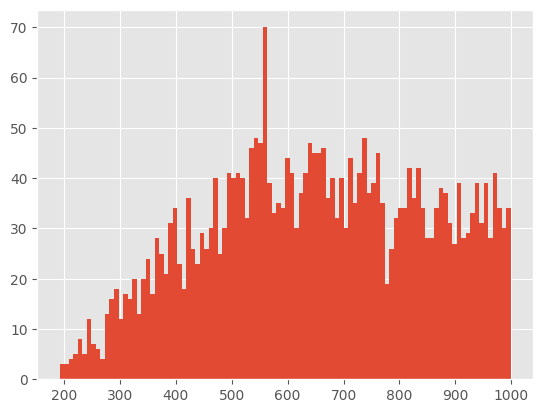

Max length: 851


In [25]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
lengths = [len(row['context'] + row['question']) for row in squad['train']]
plt.hist(lengths, bins=100)
plt.show()
target_max_length = int(np.percentile(lengths, 80))
print(f"Max length: {target_max_length}")

**Justification for prompt**

The prompts are collected from Flan 2022 Collection (Chung et al, arXiv:2210.11416).

Ref: https://arxiv.org/abs/2301.13688
Prompts are selected from this github https://github.com/google-research/FLAN/blob/main/flan/v2/flan_templates_branched.py



In [26]:
def preprocess_data(examples):
  """Adds prefix, tokenizes and sets the labels"""
  questions = examples["question"]
  contexts = examples["context"]
  titles = examples["title"]
  answers = []
  for answer in examples["answers.text"]:
    answers.append(answer[0])
  inputs = []
  for question, context in zip(questions, contexts):
    prefix = f"""Answer a question about this article:\n{context}\nQ:{question}A:"""
    input = prefix.format(context=context.strip(), question=question.strip())
    inputs.append(input)
  model_inputs = tokenizer(inputs,
                           truncation=True,
                           padding="max_length",
                           return_tensors='pt',
                           max_length=target_max_length)
  labels = tokenizer(text_target=answers, max_length=target_max_length, truncation=True)
  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

tensored_data = squad.map(preprocess_data, remove_columns=squad["train"].column_names, batched=True)

Map:   0%|          | 0/3039 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

In [27]:
tensored_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3039
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 737
    })
})

In [28]:
tokenizer.decode(tensored_data["train"][0]["input_ids"], skip_special_tokens=True)

'Answer a question about this article: Apple debuted the iTunes Wi-Fi Music Store on September 5, 2007, in its Media Event entitled "The Beat Goes On...". This service allows users to access the Music Store from either an iPhone or an iPod Touch and download songs directly to the device that can be synced to the user\'s iTunes Library over a WiFi connection, or, in the case of an iPhone, the telephone network. Q:On what date was the iTunes Wi-Fi Music Store launched?A:'

In [29]:
tokenizer.decode(tensored_data["train"][0]["labels"], skip_special_tokens=True)

'September 5, 2007'

In [30]:
tokenizer.decode(tensored_data["train"][20]["input_ids"], skip_special_tokens=True)

'Answer a question about this article: Judge Taylor appoints Atticus to defend Tom Robinson, a black man who has been accused of raping a young white woman, Mayella Ewell. Although many of Maycomb\'s citizens disapprove, Atticus agrees to defend Tom to the best of his ability. Other children taunt Jem and Scout for Atticus\'s actions, calling him a "nigger-lover". Scout is tempted to stand up for her father\'s honor by fighting, even though he has told her not to. Atticus faces a group of men intent on lynching Tom. This danger is averted when Scout, Jem, and Dill shame the mob into dispersing by forcing them to view the situation from Atticus\' and Tom\'s points of view. Q:What was the name of the woman who was allegedly raped in the book?A:'

In [31]:
tokenizer.decode(tensored_data["train"][20]["labels"], skip_special_tokens=True)

'Mayella Ewell'

In [32]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)

In [33]:
# Global Parameters
L_RATE = 5e-5
BATCH_SIZE = 8
PER_DEVICE_EVAL_BATCH = 8
WEIGHT_DECAY = 0.01
SAVE_TOTAL_LIM = 3
NUM_EPOCHS = 3

def compute_metrics(eval_preds):
   preds, labels = eval_preds
   # decode preds and labels
   labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
   decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
   decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
   # rougeLSum expects newline after each sentence
   decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
   decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
   result = rogue_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
   return result

# Set up training arguments
training_args = Seq2SeqTrainingArguments(
   output_dir="./results",
   evaluation_strategy="epoch",
   learning_rate=L_RATE,
   per_device_train_batch_size=BATCH_SIZE,
   per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH,
   weight_decay=WEIGHT_DECAY,
   save_total_limit=SAVE_TOTAL_LIM,
   num_train_epochs=NUM_EPOCHS,
   predict_with_generate=True,
   push_to_hub=False
)

## Training

In [34]:
trainer = Seq2SeqTrainer(
   model=model,
   args=training_args,
   train_dataset=tensored_data["train"],
   eval_dataset=tensored_data["test"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics
)

In [35]:
# with 5k rows in data, training time on T4 -> 10 min
# Complete dataset, 10 epochs -> 1-2 hours
trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,28.363241,0.030429,0.000000,0.030254,0.030032
2,40.592800,27.362089,0.033341,0.000000,0.033010,0.032893
3,33.236500,27.274317,0.034882,0.000000,0.034565,0.034275


TrainOutput(global_step=1140, training_loss=36.325063819216005, metrics={'train_runtime': 570.4821, 'train_samples_per_second': 15.981, 'train_steps_per_second': 1.998, 'total_flos': 1408441343173632.0, 'train_loss': 36.325063819216005, 'epoch': 3.0})

## Evaluate

In [36]:
trainer.evaluate()

{'eval_loss': 27.274316787719727,
 'eval_rouge1': 0.03488161920997741,
 'eval_rouge2': 0.0,
 'eval_rougeL': 0.03456493755001218,
 'eval_rougeLsum': 0.03427472196128911,
 'eval_runtime': 30.1475,
 'eval_samples_per_second': 24.446,
 'eval_steps_per_second': 3.085,
 'epoch': 3.0}

In [44]:
last_checkpoint = "./results/checkpoint-1000"
finetuned_model = T5ForConditionalGeneration.from_pretrained(last_checkpoint)
tokenizer = T5Tokenizer.from_pretrained(last_checkpoint)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [45]:
my_question = "What do you think about the benefit of Artificial Intelligence?"
inputs = "Please answer to this question: " + my_question
inputs = tokenizer(inputs, return_tensors="pt")
outputs = finetuned_model.generate(**inputs)
print(outputs[0])
answer = tokenizer.decode(outputs[0], skip_special_tokens=False)
print(answer)

tensor([0, 3, 9, 1])
<pad> a</s>


In [47]:
for i in range(3):
  random_idx = random.randint(0, len(squad["train"]))
  question = squad["train"][random_idx]["question"]
  context = squad["train"][random_idx]["context"]
  title = squad["train"][random_idx]["title"]
  baseline_answer = squad["train"][random_idx]["answers.text"]
  prompt = f"""Please answer a question about the following article about {title}\n{context}\n\nQ: {question}"""
  print(prompt)
  print("====="*10)
  print("Baseline answer:")
  print(baseline_answer)
  print("====="*10)
  sentence_encoded = tokenizer(prompt, return_tensors='pt', max_length=target_input_length, truncation=True)
  pred_answer = finetuned_model.generate(sentence_encoded['input_ids'], max_new_tokens=100)
  sentence_decoded = tokenizer.decode(pred_answer[0], skip_special_tokens=True)
  print("Generated Answer")
  print(sentence_decoded)
  print("====="*10)
  rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_answer])
  print(rouge_score)
  print("#####"*20)

Please answer a question about the following article about 2008_Sichuan_earthquake
Experts point out that the earthquake hit an area that has been largely neglected and untouched by China's economic rise. Health care is poor in inland areas such as Sichuan, highlighting the widening gap between prosperous urban dwellers and struggling rural people. Vice Minister of Health Gao Qiang told reporters in Beijing that the "public health care system in China is insufficient." The Vice Minister of Health also suggested that the government would pick up the costs of care to earthquake victims, many of whom have little or no insurance: "The government should be responsible for providing medical treatment to them," he said.

Q: Who was the Vice Minister of Health?
Baseline answer:
['Gao Qiang']
Generated Answer
a
{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0}
####################################################################################################
Please answer a quest

## Appendix

## Apply PEFT

Parameter efficient fine tuning is an approach towards fine tuning large language models that fine tunes the model without altering all the model weights. You can learn more about it from my block post [here](https://www.linkedin.com/pulse/finetuning-large-language-models-using-novel-peft-srikanth-machiraju-owe2c%3FtrackingId=AVwu8o6uR%252F6J3n0BB6U7IA%253D%253D/?trackingId=AVwu8o6uR%2F6J3n0BB6U7IA%3D%3D)

In [48]:
%%bash
pip install -q peft

In [65]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
print(model)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): 

In [69]:
from peft import PeftModel, PeftConfig, LoraConfig, TaskType
from peft import get_peft_config, get_peft_model, get_peft_model_state_dict, LoraConfig, TaskType

lora_config = LoraConfig(
    r=16, #Rank
    lora_alpha=32,
    target_modules=["lm_head"], # we can use layer names from above to target more modules, here I'm only training linear layer, we can also do q, v
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

peft_model = get_peft_model(model, lora_config)
peft_model = peft_model.to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_name)
peft_model.print_trainable_parameters()

training_args = Seq2SeqTrainingArguments(
   output_dir="./peft_results",
   learning_rate=1e-3,
   num_train_epochs=1,
   predict_with_generate=True
)

trainer = Seq2SeqTrainer(
   model=peft_model,
   args=training_args,
   train_dataset=tensored_data["train"],
   eval_dataset=tensored_data["test"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics
)

trainable params: 522,240 || all params: 77,483,392 || trainable%: 0.6740025010779084


In [70]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=380, training_loss=0.5706594366776315, metrics={'train_runtime': 98.2955, 'train_samples_per_second': 30.917, 'train_steps_per_second': 3.866, 'total_flos': 947064563509248.0, 'train_loss': 0.5706594366776315, 'epoch': 1.0})

In [71]:
for i in range(3):
  random_idx = random.randint(0, len(squad["train"]))
  question = squad["train"][random_idx]["question"]
  context = squad["train"][random_idx]["context"]
  title = squad["train"][random_idx]["title"]
  baseline_answer = squad["train"][random_idx]["answers.text"]
  prompt = f"""Please answer a question about the following article about {title}\n{context}\n\nQ: {question}"""
  print(prompt)
  print("====="*10)
  print("Baseline answer:")
  print(baseline_answer)
  print("====="*10)
  sentence_encoded = tokenizer(prompt, return_tensors='pt', max_length=256, truncation=True)
  peft_model = peft_model.to("cuda")
  pred_answer = peft_model.generate(input_ids=sentence_encoded['input_ids'].cuda())
  sentence_decoded = tokenizer.decode(pred_answer[0], skip_special_tokens=True)
  print("Generated Answer")
  print(sentence_decoded)
  print("====="*10)
  rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_answer])
  print(rouge_score)
  print("#####"*20)

Please answer a question about the following article about Beyoncé
At the 52nd Annual Grammy Awards, Beyoncé received ten nominations, including Album of the Year for I Am... Sasha Fierce, Record of the Year for "Halo", and Song of the Year for "Single Ladies (Put a Ring on It)", among others. She tied with Lauryn Hill for most Grammy nominations in a single year by a female artist. In 2010, Beyoncé was featured on Lady Gaga's single "Telephone" and its music video. The song topped the US Pop Songs chart, becoming the sixth number-one for both Beyoncé and Gaga, tying them with Mariah Carey for most number-ones since the Nielsen Top 40 airplay chart launched in 1992. "Telephone" received a Grammy Award nomination for Best Pop Collaboration with Vocals.

Q: Beyonce received how many nominations at the 52nd Annual Grammy Awards?
Baseline answer:
['ten nominations']
Generated Answer
ten
{'rouge1': 0.6666666666666666, 'rouge2': 0.0, 'rougeL': 0.6666666666666666, 'rougeLsum': 0.6666666666666

## Fine tuning using Human feedback

[WIP]